## Workspace Setup

In [1]:
%%capture
from google.colab import drive
drive.mount("/content/drive")
!rm -rf /content/sample_data

In [2]:
%%capture
!pip install scanpy
!pip install anndata
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install muon

In [3]:
%%capture
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import seaborn as sns
import muon as mu
import matplotlib.pyplot as plt

## Reading in files/creating objects

Copy over files from drive to pre-set folders

In [4]:
%%bash
mkdir /content/inputs
mkdir /content/inputs/E4
mkdir /content/inputs/E5
mkdir /content/inputs/E6
mkdir /content/inputs/E7

In [5]:
%%bash
cp /content/drive/MyDrive/Bioinformatics/Lab_data/multiomics/E4_filtered_feature_bc_matrix.h5 /content/inputs/E4
cp /content/drive/MyDrive/Bioinformatics/Lab_data/multiomics/E4_atac_fragments.tsv.gz /content/inputs/E4

In [6]:
%%bash
cp /content/drive/MyDrive/Bioinformatics/Lab_data/multiomics/E5_filtered_feature_bc_matrix.h5 /content/inputs/E5
cp /content/drive/MyDrive/Bioinformatics/Lab_data/multiomics/E5_atac_fragments.tsv.gz /content/inputs/E5

In [7]:
%%bash
cp /content/drive/MyDrive/Bioinformatics/Lab_data/multiomics/E6_filtered_feature_bc_matrix.h5 /content/inputs/E6
cp /content/drive/MyDrive/Bioinformatics/Lab_data/multiomics/E6_atac_fragments.tsv.gz /content/inputs/E6

In [8]:
%%bash
cp /content/drive/MyDrive/Bioinformatics/Lab_data/multiomics/E7_filtered_feature_bc_matrix.h5 /content/inputs/E7
cp /content/drive/MyDrive/Bioinformatics/Lab_data/multiomics/E7_atac_fragments.tsv.gz /content/inputs/E7

Read in .h5 files. The read_10x_h5 method is set up so that it searches h5 file's directory for .tsv fragment files. Not sure why it doesn't just allow you to specify a .tsv file to use. Not sure why there's no method to just read in .tsv by itself. Either way, that's the reason why I copied the 8 input files into their own directories.

In [9]:
%%capture
mdata_E4 = mu.read_10x_h5("/content/inputs/E4/E4_filtered_feature_bc_matrix.h5")
mdata_E4.var_names_make_unique()

mdata_E5 = mu.read_10x_h5("/content/inputs/E5/E5_filtered_feature_bc_matrix.h5")
mdata_E5.var_names_make_unique()

mdata_E6 = mu.read_10x_h5("/content/inputs/E6/E6_filtered_feature_bc_matrix.h5")
mdata_E6.var_names_make_unique()

mdata_E7 = mu.read_10x_h5("/content/inputs/E7/E7_filtered_feature_bc_matrix.h5")
mdata_E7.var_names_make_unique()

View object info to ensure proper setup:

In [10]:
mdata_E4

MuData object with n_obs × n_vars = 5812 × 85509
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	5812 x 30108
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	5812 x 55401
      var:	'gene_ids', 'feature_types', 'genome', 'interval'

In [11]:
mdata_E5

MuData object with n_obs × n_vars = 5909 × 96560
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	5909 x 30108
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	5909 x 66452
      var:	'gene_ids', 'feature_types', 'genome', 'interval'

In [12]:
mdata_E6

MuData object with n_obs × n_vars = 6854 × 86026
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	6854 x 30108
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	6854 x 55918
      var:	'gene_ids', 'feature_types', 'genome', 'interval'

In [13]:
mdata_E7

MuData object with n_obs × n_vars = 6948 × 89905
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	6948 x 30108
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	6948 x 59797
      var:	'gene_ids', 'feature_types', 'genome', 'interval'

# Begin RNA section

## QC

The first step is to create variable aliases for the RNA modalities within the objects. Because of the operations we plan to do to these aliases, we will eventually have to reassign them back to the larger mdata object.

In [14]:
rna_mod_E4 = mdata_E4.mod["rna"]
rna_mod_E5 = mdata_E5.mod["rna"]
rna_mod_E6 = mdata_E6.mod["rna"]
rna_mod_E7 = mdata_E7.mod["rna"]

In [15]:
rna_mod_E4

AnnData object with n_obs × n_vars = 5812 × 30108
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

In [16]:
rna_mod_E5

AnnData object with n_obs × n_vars = 5909 × 30108
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

In [17]:
rna_mod_E6

AnnData object with n_obs × n_vars = 6854 × 30108
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

In [18]:
rna_mod_E7

AnnData object with n_obs × n_vars = 6948 × 30108
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

Annotate mitochondrial genes:

In [19]:
rna_mod_E4.var["mt"] = rna_mod_E4.var_names.str.startswith("MT")
rna_mod_E5.var["mt"] = rna_mod_E5.var_names.str.startswith("MT")
rna_mod_E6.var["mt"] = rna_mod_E6.var_names.str.startswith("MT")
rna_mod_E7.var["mt"] = rna_mod_E7.var_names.str.startswith("MT")

Calculate QC metrics, including mitochondrial presence:

In [20]:
sc.pp.calculate_qc_metrics(rna_mod_E4, qc_vars=["mt"], inplace = True, percent_top = [20], log1p = True)
sc.pp.calculate_qc_metrics(rna_mod_E5, qc_vars=["mt"], inplace = True, percent_top = [20], log1p = True)
sc.pp.calculate_qc_metrics(rna_mod_E6, qc_vars=["mt"], inplace = True, percent_top = [20], log1p = True)
sc.pp.calculate_qc_metrics(rna_mod_E7, qc_vars=["mt"], inplace = True, percent_top = [20], log1p = True)

Define a function for filtering outliers based on a given metric and number of MADs. Taken from SC Best Practices. This replaces manually selecting QC bounds from visualizations.

In [21]:
from scipy.stats import median_abs_deviation
def find_outliers(adata, metric: str, nmads: int):
  M = adata.obs[metric]
  outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
      np.median(M) + nmads * median_abs_deviation(M) < M)
  return outlier

Define variables for QC parameters:

In [22]:
mad_gen = 5
mad_mt = 3
pct_mt = 8

E4 Filtering/QC:

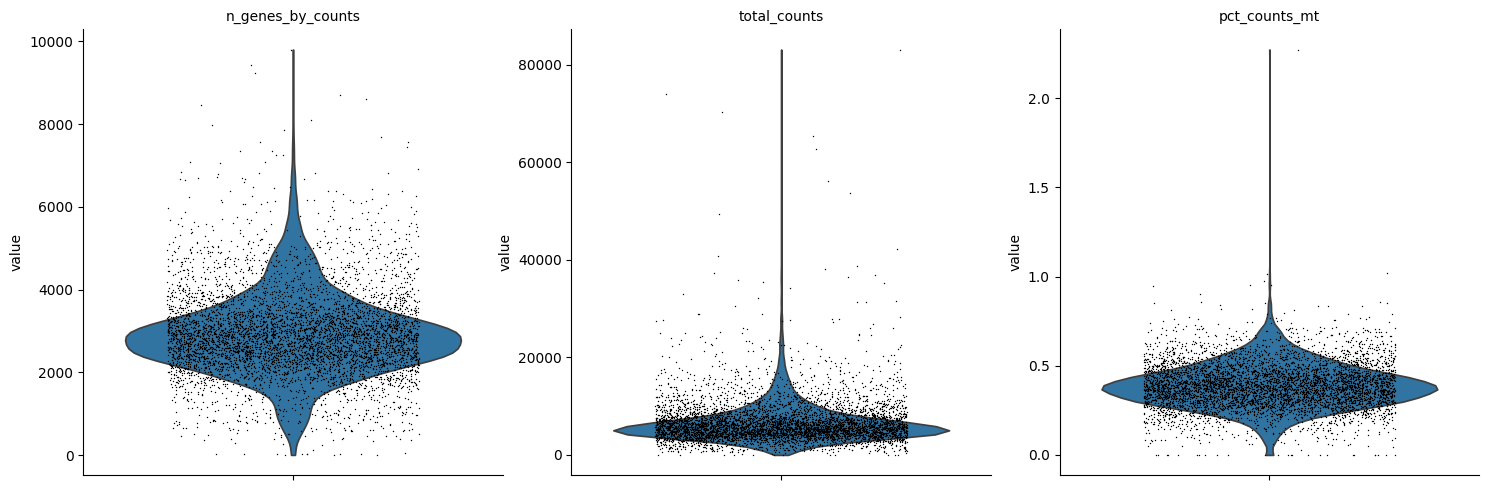

In [23]:
sc.pl.violin(rna_mod_E4, ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
             jitter=0.3, multi_panel=True)

In [24]:
rna_mod_E4.obs["outlier"] = (
    find_outliers(rna_mod_E4, "log1p_total_counts", mad_gen) |
    find_outliers(rna_mod_E4, "log1p_n_genes_by_counts", mad_gen) |
    find_outliers(rna_mod_E4, "pct_counts_in_top_20_genes", mad_gen))
rna_mod_E4.obs["mt_outlier"] = (
    find_outliers(rna_mod_E4, "pct_counts_mt", mad_mt) |
    (rna_mod_E4.obs["pct_counts_mt"] > pct_mt))

In [25]:
rna_mod_E4.obs["outlier"].value_counts()

,count
outlier,
False,5257
True,555


In [26]:
rna_mod_E4.obs["mt_outlier"].value_counts()

,count
mt_outlier,
False,5398
True,414


In [27]:
print(f"Total number of cells: {rna_mod_E4.n_obs}")
rna_mod_E4 = rna_mod_E4[(~rna_mod_E4.obs.outlier) & (~rna_mod_E4.obs.mt_outlier)]
print(f"Number of cells after filtering of low quality cells: {rna_mod_E4.n_obs}")

Total number of cells: 5812
Number of cells after filtering of low quality cells: 4954


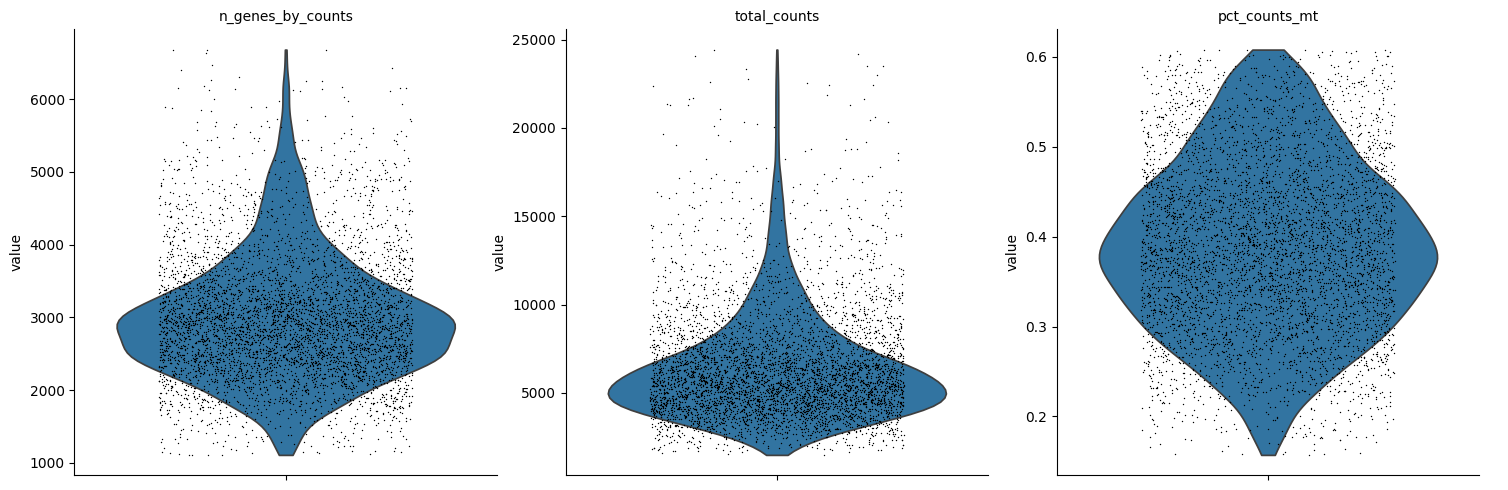

In [28]:
sc.pl.violin(rna_mod_E4, ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
             jitter=0.3, multi_panel=True)

In [29]:
rna_mod_E4

View of AnnData object with n_obs × n_vars = 4954 × 30108
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

E5 Filtering/QC:

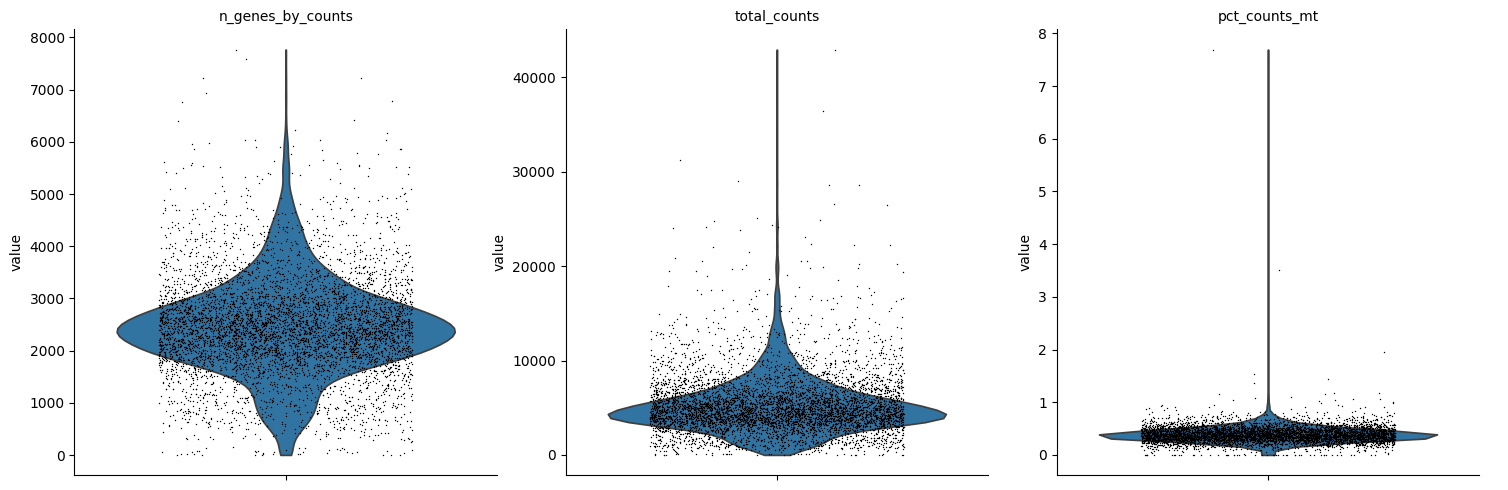

In [30]:
sc.pl.violin(rna_mod_E5, ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
             jitter=0.3, multi_panel=True)

In [31]:
rna_mod_E5.obs["outlier"] = (
    find_outliers(rna_mod_E5, "log1p_total_counts", mad_gen) |
    find_outliers(rna_mod_E5, "log1p_n_genes_by_counts", mad_gen) |
    find_outliers(rna_mod_E5, "pct_counts_in_top_20_genes", mad_gen))

rna_mod_E5.obs["mt_outlier"] = (
    find_outliers(rna_mod_E5, "pct_counts_mt", mad_mt) |
    (rna_mod_E5.obs["pct_counts_mt"] > pct_mt))

In [32]:
rna_mod_E5.obs["outlier"].value_counts()

,count
outlier,
False,5379
True,530


In [33]:
rna_mod_E5.obs["mt_outlier"].value_counts()

,count
mt_outlier,
False,5505
True,404


In [34]:
print(f"Total number of cells: {rna_mod_E5.n_obs}")
rna_mod_E5 = rna_mod_E5[(~rna_mod_E5.obs.outlier) & (~rna_mod_E5.obs.mt_outlier)]
print(f"Number of cells after filtering of low quality cells: {rna_mod_E5.n_obs}")

Total number of cells: 5909
Number of cells after filtering of low quality cells: 5112


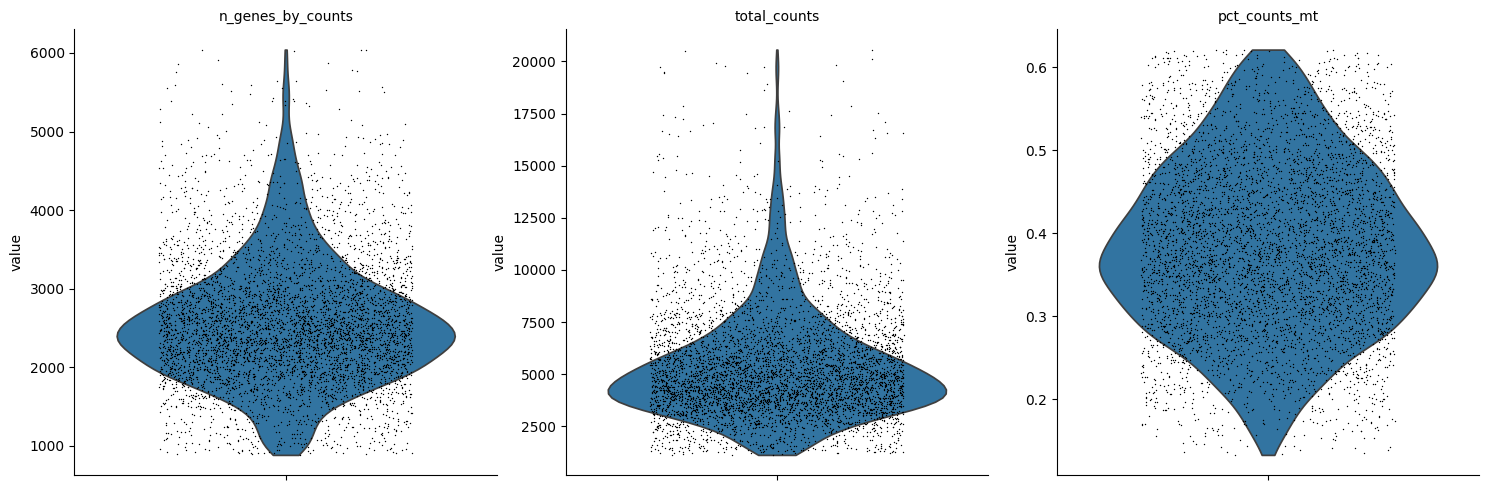

In [35]:
sc.pl.violin(rna_mod_E5, ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
             jitter=0.3, multi_panel=True)

In [36]:
rna_mod_E5

View of AnnData object with n_obs × n_vars = 5112 × 30108
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

E6 Filtering/QC:

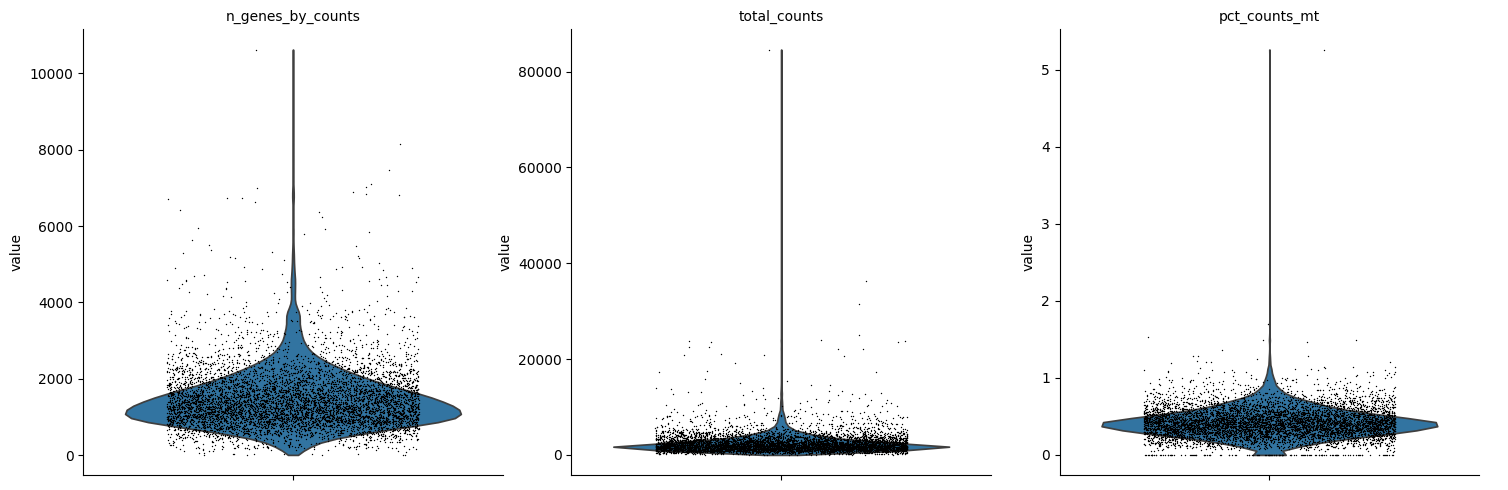

In [37]:
sc.pl.violin(rna_mod_E6, ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
             jitter=0.3, multi_panel=True)

In [38]:
rna_mod_E6.obs["outlier"] = (
    find_outliers(rna_mod_E6, "log1p_total_counts", mad_gen) |
    find_outliers(rna_mod_E6, "log1p_n_genes_by_counts", mad_gen) |
    find_outliers(rna_mod_E6, "pct_counts_in_top_20_genes", mad_gen))

rna_mod_E6.obs["mt_outlier"] = (
    find_outliers(rna_mod_E6, "pct_counts_mt", mad_mt) |
    (rna_mod_E6.obs["pct_counts_mt"] > pct_mt))

In [39]:
rna_mod_E6.obs["outlier"].value_counts()

,count
outlier,
False,6581
True,273


In [40]:
rna_mod_E6.obs["mt_outlier"].value_counts()

,count
mt_outlier,
False,6365
True,489


In [41]:
print(f"Total number of cells: {rna_mod_E6.n_obs}")
rna_mod_E6 = rna_mod_E6[(~rna_mod_E6.obs.outlier) & (~rna_mod_E6.obs.mt_outlier)]
print(f"Number of cells after filtering of low quality cells: {rna_mod_E6.n_obs}")

Total number of cells: 6854
Number of cells after filtering of low quality cells: 6183


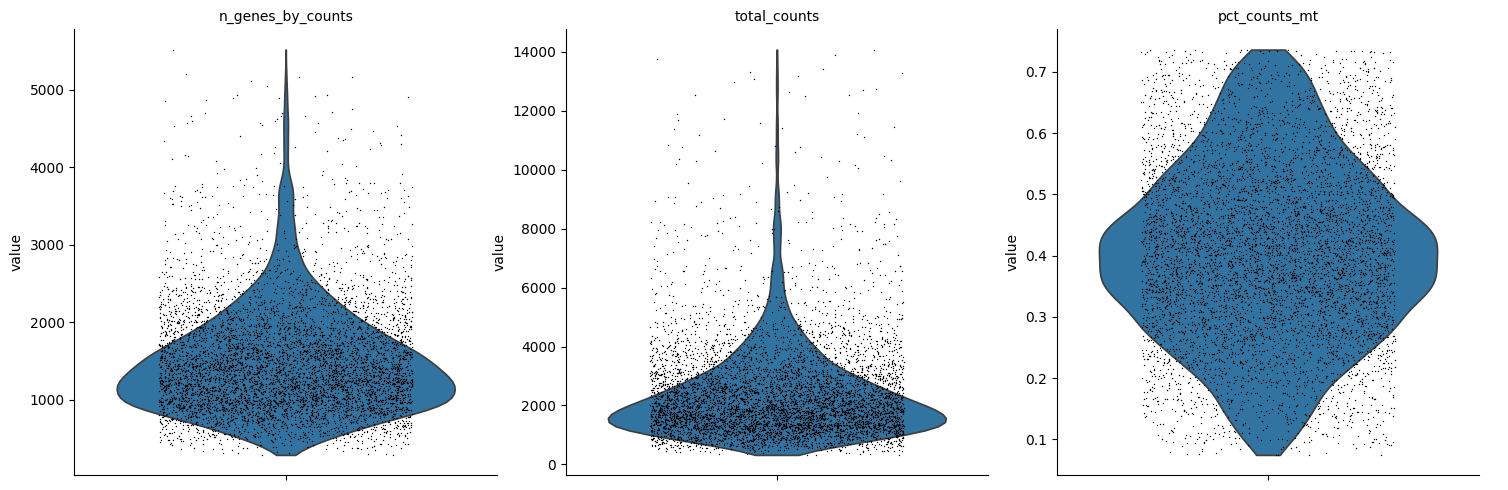

In [42]:
sc.pl.violin(rna_mod_E6, ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
             jitter=0.3, multi_panel=True)

In [43]:
rna_mod_E6

View of AnnData object with n_obs × n_vars = 6183 × 30108
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

E7 Filtering/QC:

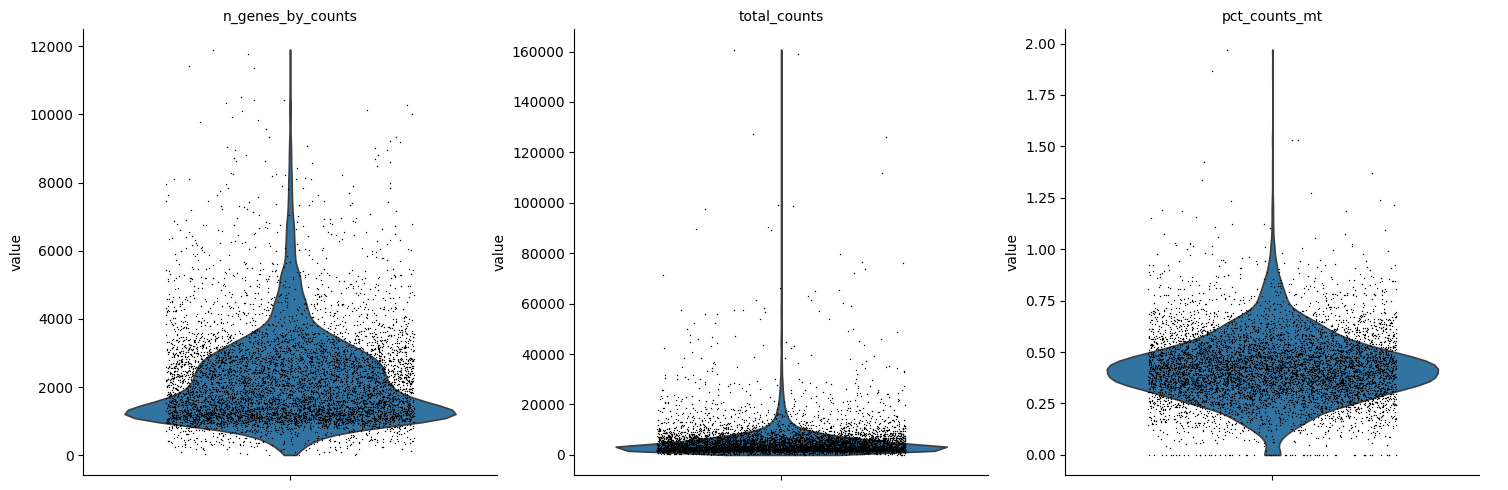

In [44]:
sc.pl.violin(rna_mod_E7, ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
             jitter=0.3, multi_panel=True)

In [45]:
rna_mod_E7.obs["outlier"] = (
    find_outliers(rna_mod_E7, "log1p_total_counts", mad_gen) |
    find_outliers(rna_mod_E7, "log1p_n_genes_by_counts", mad_gen) |
    find_outliers(rna_mod_E7, "pct_counts_in_top_20_genes", mad_gen))

rna_mod_E7.obs["mt_outlier"] = (
    find_outliers(rna_mod_E7, "pct_counts_mt", mad_mt) |
    (rna_mod_E7.obs["pct_counts_mt"] > pct_mt))

In [46]:
rna_mod_E7.obs["outlier"].value_counts()

,count
outlier,
False,6623
True,325


In [47]:
rna_mod_E7.obs["mt_outlier"].value_counts()

,count
mt_outlier,
False,6395
True,553


In [48]:
print(f"Total number of cells: {rna_mod_E7.n_obs}")
rna_mod_E7 = rna_mod_E7[(~rna_mod_E7.obs.outlier) & (~rna_mod_E7.obs.mt_outlier)]
print(f"Number of cells after filtering of low quality cells: {rna_mod_E7.n_obs}")

Total number of cells: 6948
Number of cells after filtering of low quality cells: 6131


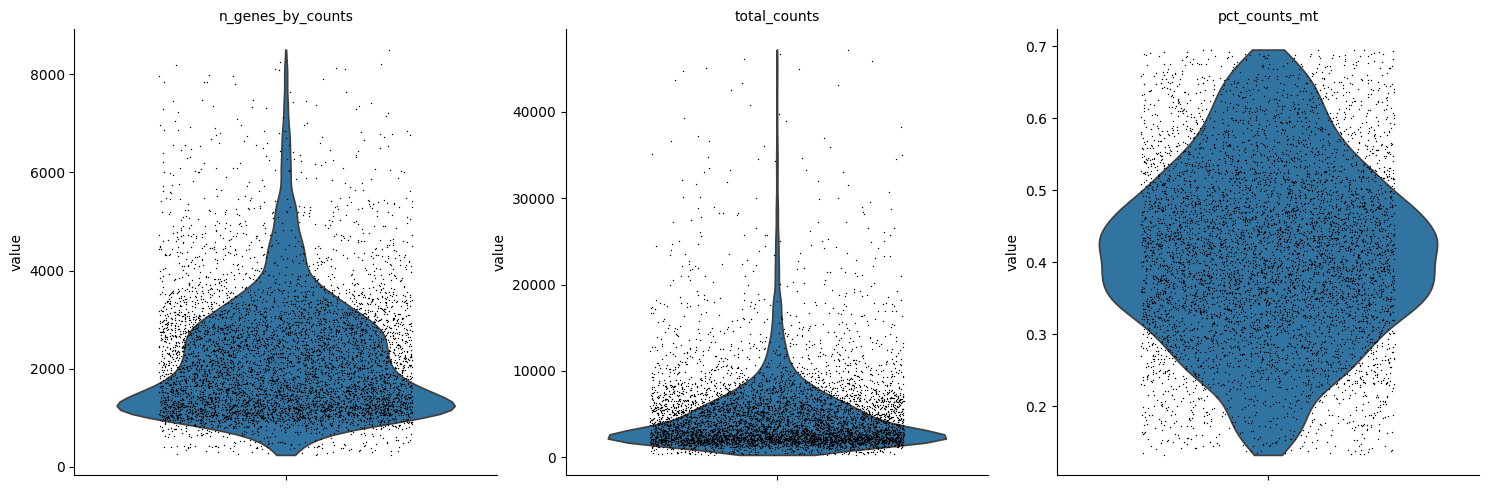

In [49]:
sc.pl.violin(rna_mod_E7, ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
             jitter=0.3, multi_panel=True)

In [64]:
rna_mod_E7

View of AnnData object with n_obs × n_vars = 6131 × 30108
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

### AMBIENT RNA DETECTION WITH SOUPX

Note: This is a suggested method from sc best practices. It's getting skipped right now, because there was a recent (large) update to the anndata2ri package that removed the 'activate' and 'py2rpy' methods that are suggested in best practices. I have not been able to find a proper solution to this.

Luckily, this count correction only affects the .X matrix, so it should all theoretically work the same. I will note this if there's any problems down the line.

Next, we will use the R package SoupX to correct for ambient/background RNA.

In [ ]:
!pip install leidenalg
!pip install igraph
!pip install anndata2ri
import logging
import anndata2ri
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
# anndata2ri.activate()
%load_ext rpy2.ipython

In [57]:
%%capture
%R .libPaths(c('/content/drive/MyDrive/Bioinformatics/Colab_Lib/R', .libPaths()))
%R library(SoupX)

SoupX is an R package, so we will need to do some R/Python interoperability here. SoupX will not adjust the number of cells or genes in our objects, it will simply adjust the counts within the large .X matrix in order to correct for detected bad data.

First, make copies of all adata objects, normalize, and run log1p transformation.

In [58]:
%%capture
E4_copy = rna_mod_E4.copy()
E5_copy = rna_mod_E5.copy()
E6_copy = rna_mod_E6.copy()
E7_copy = rna_mod_E7.copy()

sc.pp.normalize_per_cell(E4_copy)
sc.pp.normalize_per_cell(E5_copy)
sc.pp.normalize_per_cell(E6_copy)
sc.pp.normalize_per_cell(E7_copy)

sc.pp.log1p(E4_copy)
sc.pp.log1p(E5_copy)
sc.pp.log1p(E6_copy)
sc.pp.log1p(E7_copy)

Before running SoupX, we need to do some quick computations on the copied objects (PCA, KNN, Leiden clustering)

In [59]:
%%capture
sc.pp.pca(E4_copy)
sc.pp.pca(E5_copy)
sc.pp.pca(E6_copy)
sc.pp.pca(E7_copy)

sc.pp.neighbors(E4_copy)
sc.pp.neighbors(E5_copy)
sc.pp.neighbors(E6_copy)
sc.pp.neighbors(E7_copy)

sc.tl.leiden(E4_copy, key_added="soupx_groups")
sc.tl.leiden(E5_copy, key_added="soupx_groups")
sc.tl.leiden(E6_copy, key_added="soupx_groups")
sc.tl.leiden(E7_copy, key_added="soupx_groups")

Next, save the cluster groups, cell names, gene names, and (transposed) data matrices as separate objects. For the latter 3, I will copy from the filtered objects, not the "copied" ones.

In [60]:
%%capture
groups_E4 = E4_copy.obs["soupx_groups"]
groups_E5 = E5_copy.obs["soupx_groups"]
groups_E6 = E6_copy.obs["soupx_groups"]
groups_E7 = E7_copy.obs["soupx_groups"]

cells_E4 = rna_mod_E4.obs_names
cells_E5 = rna_mod_E5.obs_names
cells_E6 = rna_mod_E6.obs_names
cells_E7 = rna_mod_E7.obs_names

genes_E4 = rna_mod_E4.var_names
genes_E5 = rna_mod_E5.var_names
genes_E6 = rna_mod_E6.var_names
genes_E7 = rna_mod_E7.var_names

data_E4 = rna_mod_E4.X.T
data_E5 = rna_mod_E5.X.T
data_E6 = rna_mod_E6.X.T
data_E7 = rna_mod_E7.X.T

Our last step before running SoupX is loading in fully raw gene x cell matrices.

In [61]:
%%capture
E4_raw = sc.read_10x_h5(filename = "/content/inputs/E4/E4_filtered_feature_bc_matrix.h5")
E5_raw = sc.read_10x_h5(filename = "/content/inputs/E5/E5_filtered_feature_bc_matrix.h5")
E6_raw = sc.read_10x_h5(filename = "/content/inputs/E6/E6_filtered_feature_bc_matrix.h5")
E7_raw = sc.read_10x_h5(filename = "/content/inputs/E7/E7_filtered_feature_bc_matrix.h5")

E4_raw.var_names_make_unique()
E5_raw.var_names_make_unique()
E6_raw.var_names_make_unique()
E7_raw.var_names_make_unique()

total_data_E4 = E4_raw.X.T
total_data_E5 = E5_raw.X.T
total_data_E6 = E6_raw.X.T
total_data_E7 = E7_raw.X.T

Finally, we can construct our 4 so-called "Soup Channels" to complete the analysis. Note how the .X matrix is overwritten by the soupX_counts layer: this is because we want to use the corrected soupX counts for every downstream step from here. The raw counts are kept as a backup.

E4:

In [ ]:
%%R -i data_E4 -i total_data_E4 -i genes_E4 -i cells_E4 -i groups_E4 -o out_E4
# Specify row and column names of data
rownames(data_E4) = genes_E4
colnames(data_E4) = cells_E4
# Ensure correct sparse format for table of counts and table of droplets
data_E4 <- as(data_E4, "sparseMatrix")
total_data_E4 <- as(total_data_E4, "sparseMatrix")
# Generate SoupChannel object for SoupX
sc_E4 = SoupChannel(total_data_E4, data_E4, calcSoupProfile = FALSE)
# Add extra metadata to the SoupChannel object
soupProf_E4 = data.frame(row.names = rownames(data_E4), est = rowSums(data_E4)/sum(data_E4), counts = rowSums(data_E4))
sc_E4 = setSoupProfile(sc_E4, soupProf_E4)
# Set cluster info
sc_E4 = setClusters(sc_E4, groups_E4)
# Estimate contamintaion fraction
sc_E4 = autoEstCont(sc_E4, doPlot = FALSE)
# Infer corrected table of counts and round to integer
out_E4 = adjustCounts(sc_E4, roundToInt = TRUE)

In [ ]:
%%capture
rna_mod_E4.layers["raw_counts"] = rna_mod_E4.X
rna_mod_E4.layers["soupX_counts"] = out_E4.T
rna_mod_E4.X = rna_mod_E4.layers["soupX_counts"]

In [ ]:
rna_mod_E4

E5:

In [ ]:
%%R -i data_E5 -i total_data_E5 -i genes_E5 -i cells_E5 -i groups_E5 -o out_E5
# Specify row and column names of data
rownames(data_E5) = genes_E5
colnames(data_E5) = cells_E5
# Ensure correct sparse format for table of counts and table of droplets
data_E5 <- as(data_E5, "sparseMatrix")
total_data_E5 <- as(total_data_E5, "sparseMatrix")
# Generate SoupChannel object for SoupX
sc_E5 = SoupChannel(total_data_E5, data_E5, calcSoupProfile = FALSE)
# Add extra metadata to the SoupChannel object
soupProf_E5 = data.frame(row.names = rownames(data_E5), est = rowSums(data_E5)/sum(data_E5), counts = rowSums(data_E5))
sc_E5 = setSoupProfile(sc_E5, soupProf_E5)
# Set cluster info
sc_E5 = setClusters(sc_E5, groups_E5)
# Estimate contamintaion fraction
sc_E5 = autoEstCont(sc_E5, doPlot = FALSE)
# Infer corrected table of counts and round to integer
out_E5 = adjustCounts(sc_E5, roundToInt = TRUE)

In [ ]:
%%capture
rna_mod_E5.layers["raw_counts"] = rna_mod_E5.X
rna_mod_E5.layers["soupX_counts"] = out_E5.T
rna_mod_E5.X = rna_mod_E5.layers["soupX_counts"]

In [ ]:
rna_mod_E5

E6:

In [ ]:
%%R -i data_E6 -i total_data_E6 -i genes_E6 -i cells_E6 -i groups_E6 -o out_E6
# Specify row and column names of data
rownames(data_E6) = genes_E6
colnames(data_E6) = cells_E6
# Ensure correct sparse format for table of counts and table of droplets
data_E6 <- as(data_E6, "sparseMatrix")
total_data_E6 <- as(total_data_E6, "sparseMatrix")
# Generate SoupChannel object for SoupX
sc_E6 = SoupChannel(total_data_E6, data_E6, calcSoupProfile = FALSE)
# Add extra metadata to the SoupChannel object
soupProf_E6 = data.frame(row.names = rownames(data_E6), est = rowSums(data_E6)/sum(data_E6), counts = rowSums(data_E6))
sc_E6 = setSoupProfile(sc_E6, soupProf_E6)
# Set cluster info
sc_E6 = setClusters(sc_E6, groups_E6)
# Estimate contamintaion fraction
sc_E6 = autoEstCont(sc_E6, doPlot = FALSE)
# Infer corrected table of counts and round to integer
out_E6 = adjustCounts(sc_E6, roundToInt = TRUE)

In [ ]:
%%capture
rna_mod_E6.layers["raw_counts"] = rna_mod_E6.X
rna_mod_E6.layers["soupX_counts"] = out_E6.T
rna_mod_E6.X = rna_mod_E6.layers["soupX_counts"]

In [ ]:
rna_mod_E6

E7:

In [ ]:
%%R -i data_E7 -i total_data_E7 -i genes_E7 -i cells_E7 -i groups_E7 -o out_E7
# Specify row and column names of data
rownames(data_E7) = genes_E7
colnames(data_E7) = cells_E7
# Ensure correct sparse format for table of counts and table of droplets
data_E7 <- as(data_E7, "sparseMatrix")
total_data_E7 <- as(total_data_E7, "sparseMatrix")
# Generate SoupChannel object for SoupX
sc_E7 = SoupChannel(total_data_E7, data_E7, calcSoupProfile = FALSE)
# Add extra metadata to the SoupChannel object
soupProf_E7 = data.frame(row.names = rownames(data_E7), est = rowSums(data_E7)/sum(data_E7), counts = rowSums(data_E7))
sc_E7 = setSoupProfile(sc_E7, soupProf_E7)
# Set cluster info
sc_E7 = setClusters(sc_E7, groups_E7)
# Estimate contamintaion fraction
sc_E7 = autoEstCont(sc_E7, doPlot = FALSE)
# Infer corrected table of counts and round to integer
out_E7 = adjustCounts(sc_E7, roundToInt = TRUE)

In [ ]:
%%capture
rna_mod_E7.layers["raw_counts"] = rna_mod_E7.X
rna_mod_E7.layers["soupX_counts"] = out_E7.T
rna_mod_E7.X = rna_mod_E7.layers["soupX_counts"]

In [ ]:
rna_mod_E7

### Gene Filtering

Gene filtering: Remove genes that aren't detected by at least 5 cells in any object.

In [65]:
print(rna_mod_E4.n_vars)
print(rna_mod_E5.n_vars)
print(rna_mod_E6.n_vars)
print(rna_mod_E7.n_vars)

30108
30108
30108
30108


In [66]:
from functools import reduce
genes_E4 = set(rna_mod_E4.var_names[rna_mod_E4.X.sum(0).A1 > 5])
genes_E5 = set(rna_mod_E5.var_names[rna_mod_E5.X.sum(0).A1 > 5])
genes_E6 = set(rna_mod_E6.var_names[rna_mod_E6.X.sum(0).A1 > 5])
genes_E7 = set(rna_mod_E7.var_names[rna_mod_E7.X.sum(0).A1 > 5])
common_genes = genes_E4 | genes_E5 | genes_E6 | genes_E7
for rna in [rna_mod_E4, rna_mod_E5, rna_mod_E6, rna_mod_E7]:
    rna._inplace_subset_var([gene in common_genes for gene in rna.var_names])

In [67]:
print(rna_mod_E4.n_vars)
print(rna_mod_E5.n_vars)
print(rna_mod_E6.n_vars)
print(rna_mod_E7.n_vars)

21567
21567
21567
21567


### Doublet Detection

Note: This is having the same issue as ambient RNA detection. So I will also skip this.

I will implement the scDblFinder R package in order to find doublets.

In [68]:
%%capture
%R library(Seurat)
%R library(scater)
%R library(scDblFinder)
%R library(BiocParallel)

Copy over neccessary data from objects:

In [69]:
data_mat_E4 = rna_mod_E4.X.T
data_mat_E5 = rna_mod_E5.X.T
data_mat_E6 = rna_mod_E6.X.T
data_mat_E7 = rna_mod_E7.X.T

Now, run scDblFinder for all 4 objects

E4:

In [70]:
%%R -i data_mat_E4 -o doublet_score_E4 -o doublet_class_E4
set.seed(123)
sce_E4 = scDblFinder(SingleCellExperiment(list(counts = data_mat_E4),))
doublet_score_E4 = sce_E4$scDblFinder.score
doublet_class_E4 = sce_E4$scDblFinder.class

NotImplementedError: Conversion 'py2rpy' not defined for objects of type '<class 'scipy.sparse._csc.csc_matrix'>'

In [ ]:
rna_mod_E4.obs["scDblFinder_score"] = doublet_score_E4
rna_mod_E4.obs["scDblFinder_class"] = doublet_class_E4
rna_mod_E4.obs.scDblFinder_class.value_counts()

E5:

In [ ]:
%%R -i data_mat_E5 -o doublet_score_E5 -o doublet_class_E5
set.seed(123)
sce_E5 = scDblFinder(SingleCellExperiment(list(counts = data_mat_E5),))
doublet_score_E5 = sce_E5$scDblFinder.score
doublet_class_E5 = sce_E5$scDblFinder.class

In [ ]:
rna_mod_E5.obs["scDblFinder_score"] = doublet_score_E5
rna_mod_E5.obs["scDblFinder_class"] = doublet_class_E5
rna_mod_E5.obs.scDblFinder_class.value_counts()

E6:

In [ ]:
%%R -i data_mat_E6 -o doublet_score_E6 -o doublet_class_E6
set.seed(123)
sce_E6 = scDblFinder(SingleCellExperiment(list(counts = data_mat_E6),))
doublet_score_E6 = sce_E6$scDblFinder.score
doublet_class_E6 = sce_E6$scDblFinder.class

In [ ]:
rna_mod_E6.obs["scDblFinder_score"] = doublet_score_E6
rna_mod_E6.obs["scDblFinder_class"] = doublet_class_E6
rna_mod_E6.obs.scDblFinder_class.value_counts()

E7:

In [ ]:
%%R -i data_mat_E7 -o doublet_score_E7 -o doublet_class_E7
set.seed(123)
sce_E7 = scDblFinder(SingleCellExperiment(list(counts = data_mat_E7),))
doublet_score_E7 = sce_E7$scDblFinder.score
doublet_class_E7 = sce_E7$scDblFinder.class

In [ ]:
rna_mod_E7.obs["scDblFinder_score"] = doublet_score_E7
rna_mod_E7.obs["scDblFinder_class"] = doublet_class_E7
rna_mod_E7.obs.scDblFinder_class.value_counts()

For now, as suggested, I will leave the doublets in the data set and inspect their presence later in visualizations.

In [ ]:
rna_mod_E4

In [ ]:
rna_mod_E5

In [ ]:
rna_mod_E6

In [ ]:
rna_mod_E7

## Normalization

In this section, we will apply shifted logarithm normalization to the RNA objects.

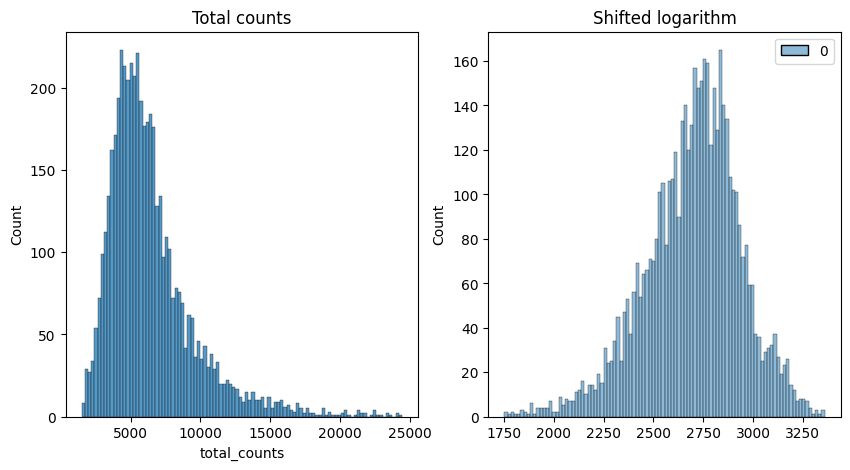

In [71]:
# E4 Normalization
scaled_counts_E4 = sc.pp.normalize_total(rna_mod_E4, target_sum=None, inplace=False)
rna_mod_E4.layers["soupX_log1p_norm"] = sc.pp.log1p(scaled_counts_E4["X"], copy=True)
rna_mod_E4.X = rna_mod_E4.layers["soupX_log1p_norm"].copy()
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(rna_mod_E4.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(rna_mod_E4.layers["soupX_log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()

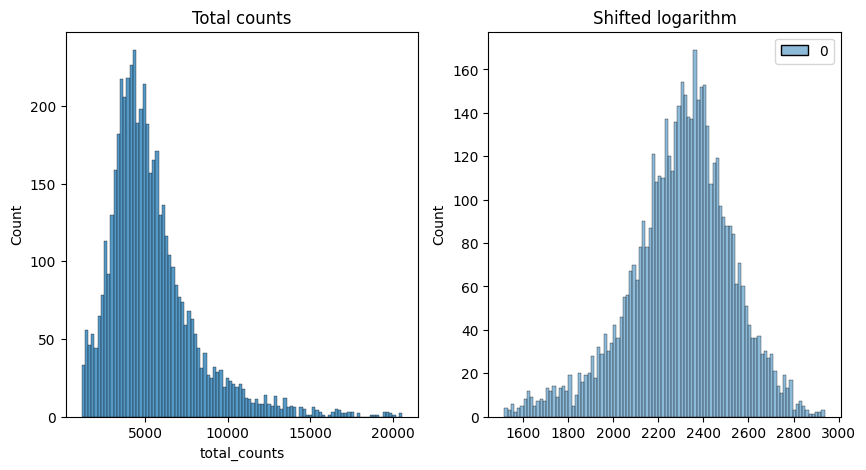

In [72]:
# E5 Normalization
scaled_counts_E5 = sc.pp.normalize_total(rna_mod_E5, target_sum=None, inplace=False)
rna_mod_E5.layers["soupX_log1p_norm"] = sc.pp.log1p(scaled_counts_E5["X"], copy=True)
rna_mod_E5.X = rna_mod_E5.layers["soupX_log1p_norm"].copy()
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(rna_mod_E5.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(rna_mod_E5.layers["soupX_log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()

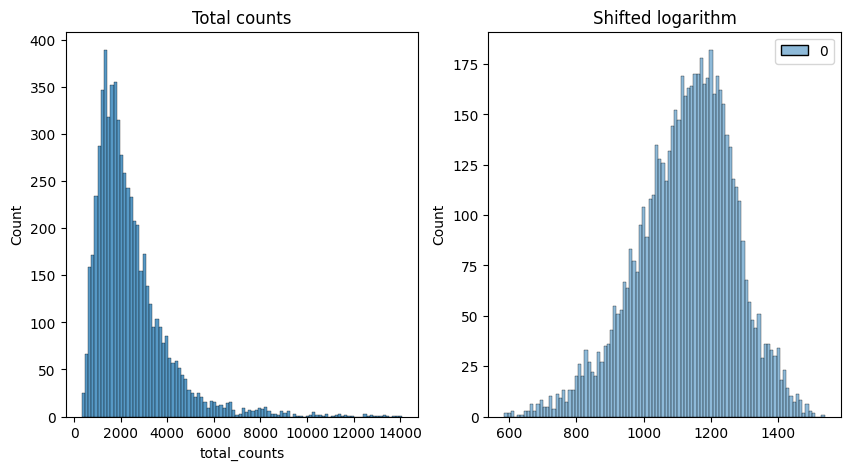

In [73]:
# E6 Normalization
scaled_counts_E6 = sc.pp.normalize_total(rna_mod_E6, target_sum=None, inplace=False)
rna_mod_E6.layers["soupX_log1p_norm"] = sc.pp.log1p(scaled_counts_E6["X"], copy=True)
rna_mod_E6.X = rna_mod_E6.layers["soupX_log1p_norm"].copy()
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(rna_mod_E6.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(rna_mod_E6.layers["soupX_log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()

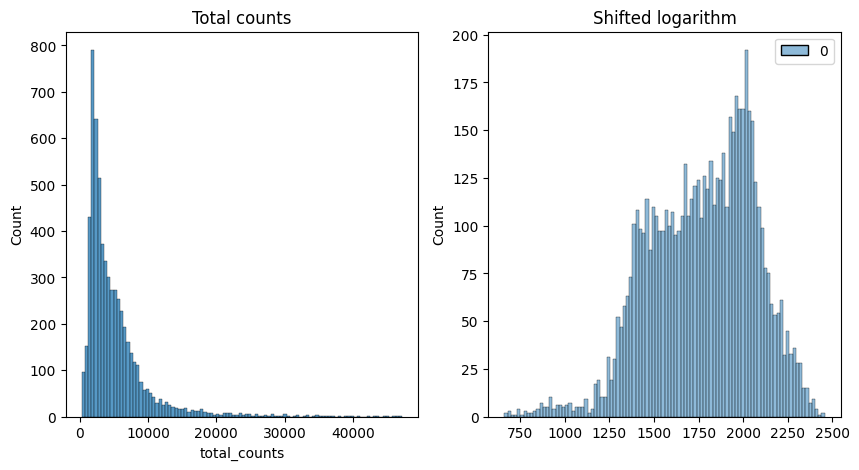

In [74]:
# E7 Normalization
scaled_counts_E7 = sc.pp.normalize_total(rna_mod_E7, target_sum=None, inplace=False)
rna_mod_E7.layers["soupX_log1p_norm"] = sc.pp.log1p(scaled_counts_E7["X"], copy=True)
rna_mod_E7.X = rna_mod_E7.layers["soupX_log1p_norm"].copy()
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(rna_mod_E7.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(rna_mod_E7.layers["soupX_log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()

In [75]:
rna_mod_E4

AnnData object with n_obs × n_vars = 4954 × 21567
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'soupX_log1p_norm'

In [76]:
rna_mod_E5

AnnData object with n_obs × n_vars = 5112 × 21567
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'soupX_log1p_norm'

In [77]:
rna_mod_E6

AnnData object with n_obs × n_vars = 6183 × 21567
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'soupX_log1p_norm'

In [78]:
rna_mod_E7

AnnData object with n_obs × n_vars = 6131 × 21567
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'soupX_log1p_norm'

At this point, we have 3 different layers. Raw counts is pre-soupX correction counts. soupX_counts have been corrected but not normalized, and soupX_log1p_norm has been normalized. As you can see in the above cells, the .X matrices have been set to be equal to the corrected and normalized layer.

# Selecting Highly Variable Genes (HVG)

NOTE: The best practices website suggests a different method, but it's not working.

Next, I will run some simple (default) code to select highly variable genes from each object. This will not remove any genes that aren't highly variable, but it will mark them, and I will inspect that marking.

In [79]:
### E4 ###
sc.pp.highly_variable_genes(rna_mod_E4)

hvgs = rna_mod_E4.var['highly_variable']
print("Highly variable genes:", hvgs.sum())
print("Not highly variable genes:", (~hvgs).sum())

Highly variable genes: 2565
Not highly variable genes: 19002


In [80]:
### E5 ###
sc.pp.highly_variable_genes(rna_mod_E5)

hvgs = rna_mod_E5.var['highly_variable']
print("Highly variable genes:", hvgs.sum())
print("Not highly variable genes:", (~hvgs).sum())

Highly variable genes: 2648
Not highly variable genes: 18919


In [81]:
### E6 ###
sc.pp.highly_variable_genes(rna_mod_E6)

hvgs = rna_mod_E6.var['highly_variable']
print("Highly variable genes:", hvgs.sum())
print("Not highly variable genes:", (~hvgs).sum())

Highly variable genes: 2358
Not highly variable genes: 19209


In [82]:
### E7 ###
sc.pp.highly_variable_genes(rna_mod_E7)

hvgs = rna_mod_E7.var['highly_variable']
print("Highly variable genes:", hvgs.sum())
print("Not highly variable genes:", (~hvgs).sum())

Highly variable genes: 3003
Not highly variable genes: 18564


Now, RNA QC and normalization is done. We have filtered using the MAD method, corrected counts for ambient RNA with SoupX, filtered genes based on detection, annotated doublets with scDblFinder, normalized (while keeping the raw counts), and now run feature selection and annotated each gene. I have not yet filtered based on doublet detection or highly variable genes, but that can easily be done in the future. One final object inspection:

In [83]:
rna_mod_E4

AnnData object with n_obs × n_vars = 4954 × 21567
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    layers: 'soupX_log1p_norm'

In [84]:
rna_mod_E5

AnnData object with n_obs × n_vars = 5112 × 21567
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    layers: 'soupX_log1p_norm'

In [85]:
rna_mod_E6

AnnData object with n_obs × n_vars = 6183 × 21567
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    layers: 'soupX_log1p_norm'

In [86]:
rna_mod_E7

AnnData object with n_obs × n_vars = 6131 × 21567
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'outlier', 'mt_outlier'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    layers: 'soupX_log1p_norm'

# Begin ATAC section

In [95]:
from muon import atac as ac

In [87]:
atac_mod_E4 = mdata_E4.mod["atac"]
atac_mod_E5 = mdata_E5.mod["atac"]
atac_mod_E6 = mdata_E6.mod["atac"]
atac_mod_E7 = mdata_E7.mod["atac"]

In [88]:
atac_mod_E4

AnnData object with n_obs × n_vars = 5812 × 55401
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

In [89]:
atac_mod_E5

AnnData object with n_obs × n_vars = 5909 × 66452
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

In [90]:
atac_mod_E6

AnnData object with n_obs × n_vars = 6854 × 55918
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

In [91]:
atac_mod_E7

AnnData object with n_obs × n_vars = 6948 × 59797
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

### ATAC Doublet Detection

Note: I am skipping the Best Practices-suggested doublet detection here, again. Same issues as above. Hopefully to be added later.

In [ ]:
# PLACEHOLDER

### ATAC QC

Here are the primary QC metrics for our ATAC data:


*   Total Fragment Counts - total number of fragments per cell. Analogous to number of total counts for RNA data.
*   TSS Enrichment Score - Ratio of fragmetns centered at the TSS to fragments in TSS-flanking regions. This is like a signal-to-noise ratio.
*   Number of Features Per Cell - Number of peaks with non-zero counts in each cell. Analogous to number of genes detected in RNA data.
*   Nucleosome Signal Score - Another kind of signal-to-noise ratio.



Run Calculate_QC_metrics for each object:

In [92]:
sc.pp.calculate_qc_metrics(atac_mod_E4, percent_top = None, log1p = False, inplace = True)
sc.pp.calculate_qc_metrics(atac_mod_E5, percent_top = None, log1p = False, inplace = True)
sc.pp.calculate_qc_metrics(atac_mod_E6, percent_top = None, log1p = False, inplace = True)
sc.pp.calculate_qc_metrics(atac_mod_E7, percent_top = None, log1p = False, inplace = True)

Rename columns to match the actual ATAC data:

In [93]:
atac_mod_E4.obs.rename(columns={
        "n_genes_by_counts": "n_features_per_cell",
        "total_counts": "total_fragment_counts", } , inplace=True, )

atac_mod_E5.obs.rename(columns={
        "n_genes_by_counts": "n_features_per_cell",
        "total_counts": "total_fragment_counts", } , inplace=True, )

atac_mod_E6.obs.rename(columns={
        "n_genes_by_counts": "n_features_per_cell",
        "total_counts": "total_fragment_counts", } , inplace=True, )

atac_mod_E7.obs.rename(columns={
        "n_genes_by_counts": "n_features_per_cell",
        "total_counts": "total_fragment_counts", } , inplace=True, )

Run log-transformation of total counts and add as a separate column:

In [94]:
atac_mod_E4.obs["log_total_fragment_counts"] = np.log10(atac_mod_E4.obs["total_fragment_counts"])
atac_mod_E5.obs["log_total_fragment_counts"] = np.log10(atac_mod_E5.obs["total_fragment_counts"])
atac_mod_E6.obs["log_total_fragment_counts"] = np.log10(atac_mod_E6.obs["total_fragment_counts"])
atac_mod_E7.obs["log_total_fragment_counts"] = np.log10(atac_mod_E7.obs["total_fragment_counts"])

Run Nucleosome Signal Calculation

In [98]:
!pip install pysam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 113.8 MB/s eta 0:00:00


In [101]:
%%bash
cp /content/drive/MyDrive/Bioinformatics/Lab_data/multiomics/E4_atac_fragments.tsv.gz.tbi /content/inputs/E4
cp /content/drive/MyDrive/Bioinformatics/Lab_data/multiomics/E5_atac_fragments.tsv.gz.tbi /content/inputs/E5
cp /content/drive/MyDrive/Bioinformatics/Lab_data/multiomics/E6_atac_fragments.tsv.gz.tbi /content/inputs/E6
cp /content/drive/MyDrive/Bioinformatics/Lab_data/multiomics/E7_atac_fragments.tsv.gz.tbi /content/inputs/E7

In [102]:
ac.tl.locate_fragments(atac_mod_E4, fragments = "/content/inputs/E4/E4_atac_fragments.tsv.gz")
ac.tl.locate_fragments(atac_mod_E5, fragments = "/content/inputs/E5/E5_atac_fragments.tsv.gz")
ac.tl.locate_fragments(atac_mod_E6, fragments = "/content/inputs/E6/E6_atac_fragments.tsv.gz")
ac.tl.locate_fragments(atac_mod_E7, fragments = "/content/inputs/E7/E7_atac_fragments.tsv.gz")

In [103]:
ac.tl.nucleosome_signal(atac_mod_E4)
ac.tl.nucleosome_signal(atac_mod_E5)
ac.tl.nucleosome_signal(atac_mod_E6)
ac.tl.nucleosome_signal(atac_mod_E7)

Reading Fragments: 100%|██████████| 69480000/69480000 [03:30<00:00, 330046.25it/s]
